# Hydro energy generation for Eastern and North-Eastern regions of India

### Importing libraries and setting figure size and style

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('fivethirtyeight')

### Loading the dataset for Hydro energy generation for Eastern and North-Eastern regions of India

In [ ]:
df = pd.read_csv('/content/eastern-hydro.csv', index_col=0, parse_dates=True)
df = df.asfreq('MS')
df.head()

,ACTUAL
Date,
2020-09-01,3334.23
2020-10-01,2991.53
2020-11-01,1686.06
2020-12-01,1263.04
2021-01-01,1237.07


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2020-09-01 to 2022-08-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ACTUAL  24 non-null     float64
dtypes: float64(1)
memory usage: 384.0 bytes


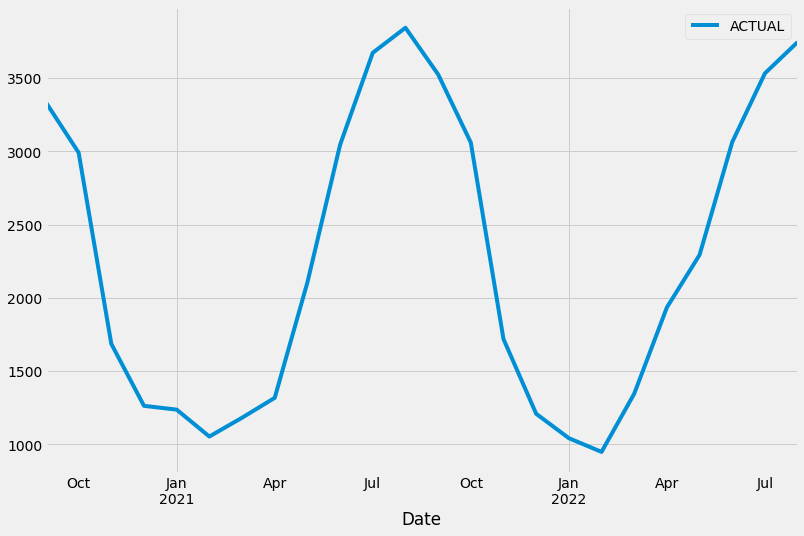

In [ ]:
df.plot()

## Exploratory data analysis

### Checking for seasonality

In [ ]:
X = df.values

In [ ]:
from math import sin
from math import radians
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced forecast
def inverse_difference(last_ob, value):
	return value + last_ob

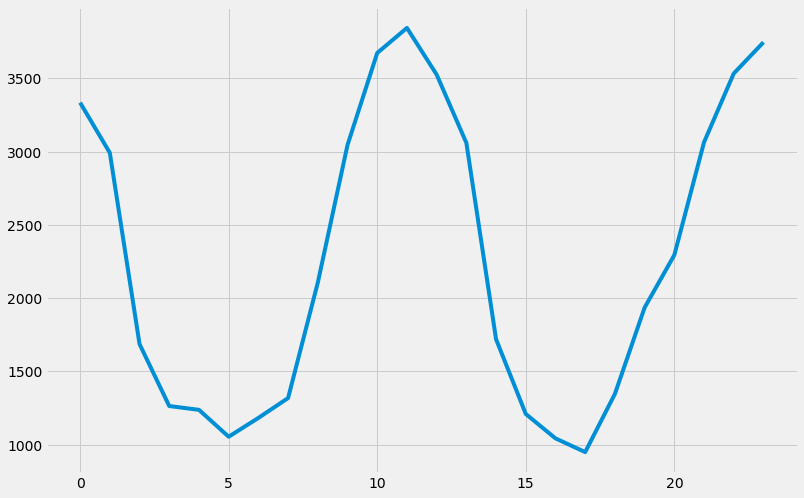

In [ ]:
# Plotting the dataset
pyplot.plot(X)
pyplot.show()

Clearly, seasonality can be observed in the dataset.

#### Differencing to Remove Seasonality

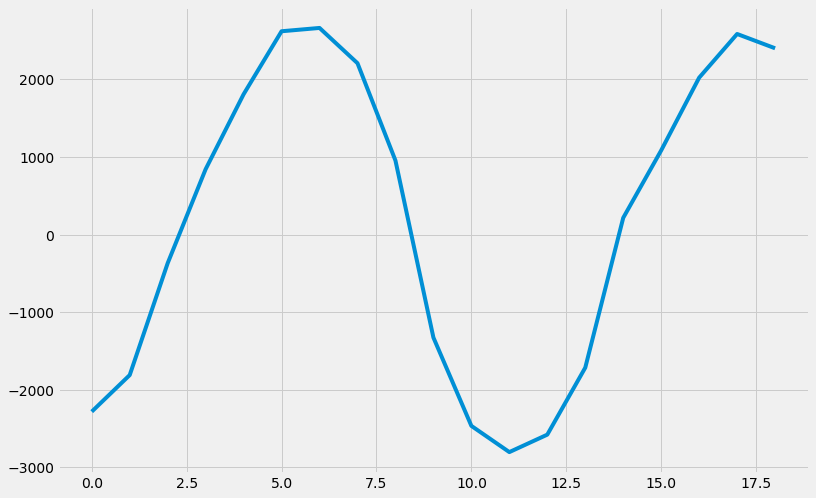

In [ ]:
# Applying difference transform to the dataset and plotting
diff = difference(X, 5)
pyplot.plot(diff)
pyplot.show()

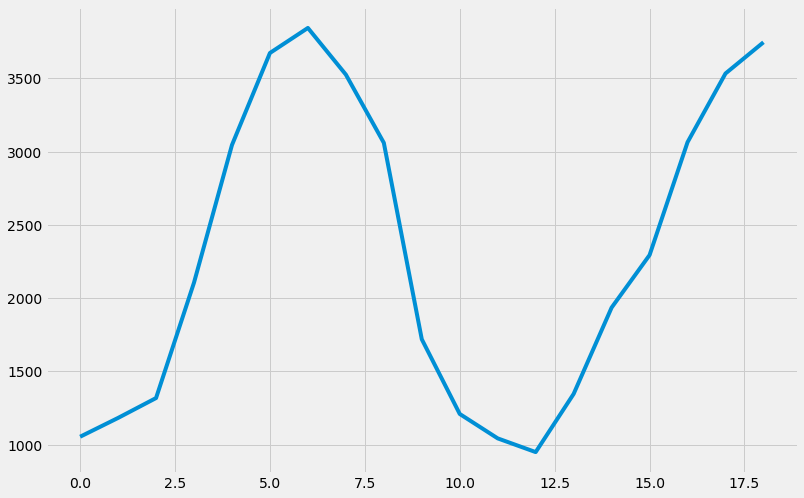

In [ ]:
# Finally, the transform is inverted showing the second cycle with the seasonality restored.
inverted = [inverse_difference(X[i], diff[i]) for i in range(len(diff))]
pyplot.plot(inverted)
pyplot.show()

### Checking for Stationarity

Using **Dickey-Fuller test** since it is a more accurate method.

Sign of obvious trends, seasonality, or other systematic structures in the series are indicators of a non-stationary series.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.


Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have a time-dependent structure.


We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).


*p-value* > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


*p-value* <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.551222
p-value: 0.103503
Critical Values:
	1%: -4.012
	5%: -3.104
	10%: -2.691


Hence, this data is non-stationary.

Performing log-transformation of data to convert non-stationary data to stationary data

In [ ]:
X = np.log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.261800
p-value: 0.184584
	1%: -4.012
	5%: -3.104
	10%: -2.691


Data is still non-stationary.

#### Transforming non-stationary series to make it stationary

Using differencing (involves taking the differences of consecutive observations)

In [ ]:
Xd = df.diff(periods=1)

In [ ]:
Xd

,ACTUAL
Date,
2020-09-01,NaN
2020-10-01,-342.70
2020-11-01,-1305.47
2020-12-01,-423.02
2021-01-01,-25.97
2021-02-01,-183.55
2021-03-01,128.30
2021-04-01,135.76
2021-05-01,788.01


In [ ]:
results = adfuller(Xd.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.977566
p-value: 0.001533
Critical Values:
	1%: -3.964
	5%: -3.085
	10%: -2.682


Now, the data is stationary since p-value<0.05

### Autocorrelation analysis

Using Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to decide whether some data is best suited to an MA model or an AR model.

Selecting the right model order is of great importance to predictions.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


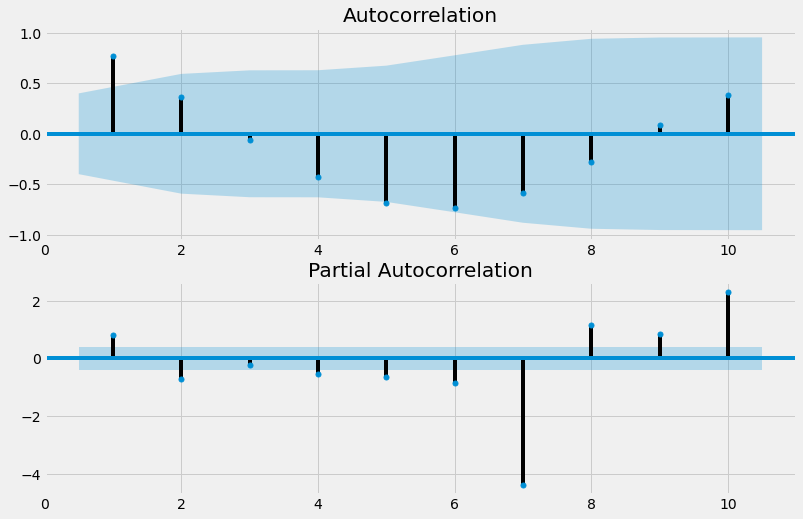

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF of df
plot_acf(df, lags=10, zero=False, ax=ax1);

# Plot the PACF of df
plot_pacf(df, lags=10, zero=False, ax=ax2);

#### Interpretation of the plots

Blue area depicts the 95% confidence interval and is an indicator of the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.

**Strong correlation at a lag of 7 in PACF plot**
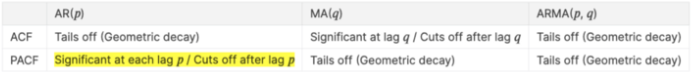

Hence, we try AR(p=7) model

## Implementing AutoRegression models

### Implementing Auto Regressive model with p = 7

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(df['ACTUAL'], lags = 7).fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 ACTUAL   No. Observations:                   24
Model:                     AutoReg(7)   Log Likelihood                -114.041
Method:               Conditional MLE   S.D. of innovations            198.216
Date:                Tue, 01 Nov 2022   AIC                            246.082
Time:                        16:13:39   BIC                            253.581
Sample:                    04-01-2021   HQIC                           246.827
                         - 08-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2802.0919    637.975      4.392      0.000    1551.684    4052.499
ACTUAL.L1      0.7361      0.223      3.307      0.001       0.300       1.172
ACTUAL.L2     -0.1464      0.282     -0.519      0.603      -0.699       0.406
ACTUAL.L3     -0.2316      0.280     -0.826      0.409      -0.781       0.318
ACTUAL.L4     -0.3199      0.282     -1.133      0.257      -0.873       0.233
ACTUAL.L5      0.2087      0.266      0.784      0.433      -0.313       0.731
ACTUAL.L6     -0.2002      0.225     -0.891      0.373      -0.641       0.240
ACTUAL.L7     -0.2878      0.189     -1.524      0.127      -0.658       0.082
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8647           -0.5063j            1.0020           -0.0843
AR.2            0.8647           +0.5063j            1.0020            0.0843
AR.3            0.4797           -1.0567j            1.1605           -0.1822
AR.4            0.4797           +1.0567j            1.1605            0.1822
AR.5           -0.8368           -0.8954j            1.2255           -0.3696
AR.6           -0.8368           +0.8954j            1.2255            0.3696
AR.7           -1.7109           -0.0000j            1.7109           -0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(ar_model.resid))
# Print mean absolute error
print(mae)

133.4109679557492


### Autocorrelation analysis with Stationary data

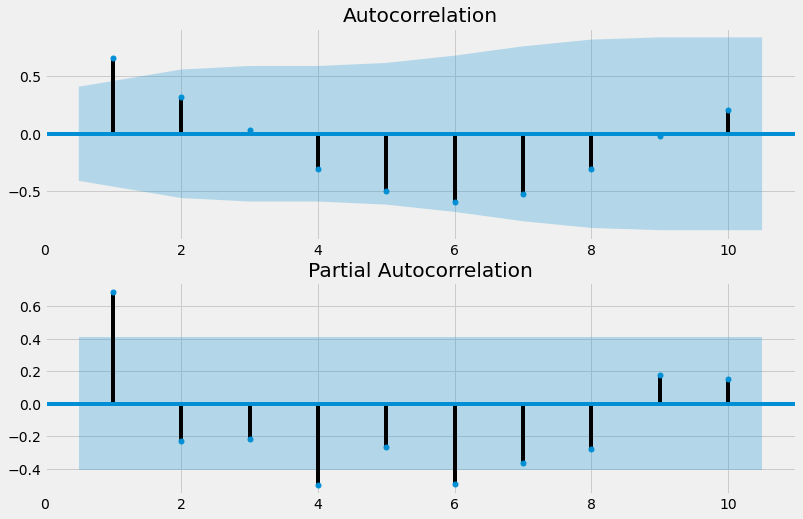

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF of df
plot_acf(Xd.dropna(), lags=10, zero=False, ax=ax1);

# Plot the PACF of df
plot_pacf(Xd.dropna(), lags=10, zero=False, ax=ax2);

#### Interpretation of the plots

Blue area depicts the 95% confidence interval and is an indicator of the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.

High degree of autocorrelation between adjacent (lag = 1) in PACF plot
Geometric decay in ACF plot

Based on the above table, we can use an AR(1) model to model this process.
With AR(p=1), the formula


can be rewritten to the following:



In [ ]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(Xd[['ACTUAL']], lags = 1).fit()
ar_model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 ACTUAL   No. Observations:                   23
Model:                     AutoReg(1)   Log Likelihood                -165.287
Method:               Conditional MLE   S.D. of innovations            443.247
Date:                Tue, 01 Nov 2022   AIC                             12.461
Time:                        13:03:41   BIC                             12.610
Sample:                    11-01-2020   HQIC                            12.496
                         - 08-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     28.3225     94.511      0.300      0.764    -156.916     213.561
ACTUAL.L1      0.6615      0.158      4.183      0.000       0.351       0.971
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5118           +0.0000j            1.5118            0.0000
-----------------------------------------------------------------------------
"""

AR(1) model fits an alpha_1 = 0.6615, which is  close to the alpha_1 = 0.5 that we have set.

In [ ]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(ar_model.resid))
# Print mean absolute error
print(mae)

333.26542624648414


Since the error is high, other models are explored.

## SARIMA models

## SARIMAX model

SARIMAX(Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) is an updated version of the ARIMA model. we can say SARIMAX is a seasonal equivalent model like SARIMA and Auto ARIMA. it can also deal with external effects. This feature of the model differs from other models.

#### Seasonal Decomposition

Time series can be composed of trend, seasonal and residual components.

Seasonal data
- Has predictable and repeated patterns
- Repeats after any amount of time

Seasonal decomposition
- time series = trend + seasonal + residual

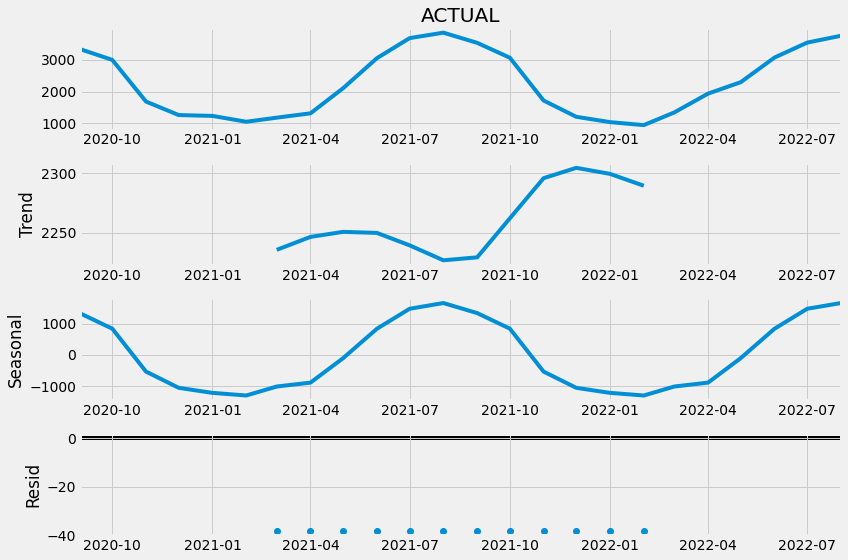

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
decomp = seasonal_decompose(df['ACTUAL'], period=12)

# Plot decomposition
decomp.plot();
plt.tight_layout();

Based on this figure, 9 time steps is the time period of the seasonal component.

Seasonal ARIMA = SARIMA

SARIMA(p,d,q)(P,D,Q)_s

**Non-seasonal orders**

p: autoregressive order

d: differencing order

q: moving average order


**Seasonal orders**

P: seasonal autoregressive order

D: seasonal differencing order

Q: seasonal moving average order

S: Number of time steps per cycle

#### Differencing and fitting ARMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
data_diff = df.diff().dropna()

# Creating a simple ARMA(0, 2, 2) model
arma = SARIMAX(data_diff, order=(0, 2, 2))

# Fit model
arma_results = arma.fit()

# Print fit summary
print(arma_results.summary())

                               SARIMAX Results                                
Dep. Variable:                 ACTUAL   No. Observations:                   23
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -161.285
Date:                Tue, 01 Nov 2022   AIC                            328.569
Time:                        16:40:32   BIC                            331.703
Sample:                    10-01-2020   HQIC                           329.249
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0503      0.305     -3.447      0.001      -1.647      -0.453
ma.L2          0.0504      0.233      0.217      0.828      -0.406       0.506
sigma2      2.461e+05   1.25e-06   1.98e+11      0.0

Unrolling ARMA forecast

In [ ]:
arma_diff_forecast = arma_results.get_forecast(steps=5).predicted_mean

# Integrate the difference forecast
arma_int_forecast = np.cumsum(arma_diff_forecast)

# Make absolute value forecast
arma_value_forecast = arma_int_forecast + df.iloc[-1, 0]

# Print forecast
print("PREDICTIONS FOR NEXT 5 MONTHS: ")
print(arma_value_forecast)

PREDICTIONS FOR NEXT 5 MONTHS: 
2022-09-01    3998.525633
2022-10-01    4275.154935
2022-11-01    4576.117905
2022-12-01    4901.414544
2023-01-01    5251.044852
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arma_results.resid))

# Print mean absolute error
print(mae)

450.0857309573277


#### Fitting an ARIMA model using statsmodels instead of modeling the difference and then integrating

In [ ]:
arima = SARIMAX(df, order=(0,2,0))

# Fit ARIMA model
arima_results = arima.fit()

# Make ARIMA forecast of next 5 values
arima_value_forecast = arima_results.get_forecast(steps=5).predicted_mean

# Print forecast
print("PREDICTIONS FOR NEXT 5 MONTHS: ")
print(arima_value_forecast)

PREDICTIONS FOR NEXT 5 MONTHS: 
2022-09-01    3959.27
2022-10-01    4172.31
2022-11-01    4385.35
2022-12-01    4598.39
2023-01-01    4811.43
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print(mae)

457.8264998578784


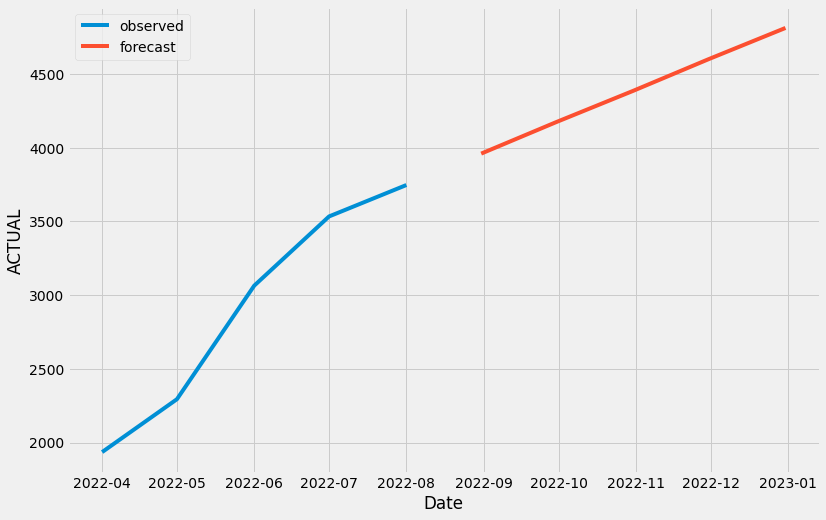

In [ ]:
plt.plot(df.index[-5:], df.iloc[-5:]['ACTUAL'], label='observed');

# Plot your mean forecast
rng = pd.date_range(start='2022-08-01', end='2023-01-01',freq='M')
plt.plot(rng, arima_value_forecast.values, label='forecast');

# set labels, legends
plt.xlabel('Date');
plt.ylabel('ACTUAL');
plt.legend();


## Evaluating ARIMA model parameters

In [ ]:
X = df['ACTUAL']
X.head()

Date
2020-09-01    3334.23
2020-10-01    2991.53
2020-11-01    1686.06
2020-12-01    1263.04
2021-01-01    1237.07
Freq: MS, Name: ACTUAL, dtype: float64

In [ ]:
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  train_size = int(len(X) * 0.66)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
      model = ARIMA(history, order=arima_order)
      model_fit = model.fit(disp=0)
      yhat = model_fit.forecast()[0]
      predictions.append(yhat)
      history.append(test[t])
  # calculate out of sample error
  error = mean_squared_error(test, predictions)
  return error

In [ ]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA model: %s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

evaluate_models(df.values, p_values, d_values, q_values)

Best ARIMA model: None MSE=inf


## Automated SARIMA model selection

### Using pmdarima package

In [ ]:
# !pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.9 MB/s 
     |████████████████████████████████| 9.8 MB 24.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import pmdarima as pm

# Create auto_arima model
model1 = pm.auto_arima(df,
                      seasonal=True, m=7,
                      d=0, D=1,
                      max_p=2, max_q=2,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)

# Print model summary
print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=309.703, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=292.600, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=307.969, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=296.289, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=289.072, Time=0.49 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=282.772, Time=0.72 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=285.083, Time=0.28 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,1)(

Using AIC (Akaike Information Criterion), best SARIMA model is chosen

Lower AIC indicates a better model

AIC likes to choose simple models with lower order

## SARIMA vs ARIMA forecasts

In [ ]:
model = SARIMAX(df, order=(2,0,0), trend='c',
                enforce_stationarity=True, enforce_invertibility=True)

arima_results = model.fit()

In [ ]:
arima_results.specification

{'seasonal_periods': 0,
 'measurement_error': False,
 'time_varying_regression': False,
 'simple_differencing': False,
 'enforce_stationarity': True,
 'enforce_invertibility': True,
 'hamilton_representation': False,
 'concentrate_scale': False,
 'trend_offset': 1,
 'order': (2, 0, 0),
 'seasonal_order': (0, 0, 0, 0),
 'k_diff': 0,
 'k_seasonal_diff': 0,
 'k_ar': 2,
 'k_ma': 0,
 'k_seasonal_ar': 0,
 'k_seasonal_ma': 0,
 'k_ar_params': 2,
 'k_ma_params': 0,
 'trend': 'c',
 'k_trend': 1,
 'k_exog': 0,
 'mle_regression': False,
 'state_regression': False}

In [ ]:
model = SARIMAX(df, order=(2,0,1), seasonal_order=(2,0,1,7), trend='c',
                enforce_stationarity=True, enforce_invertibility=True)

sarima_results = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
sarima_results.specification

{'seasonal_periods': 7,
 'measurement_error': False,
 'time_varying_regression': False,
 'simple_differencing': False,
 'enforce_stationarity': True,
 'enforce_invertibility': True,
 'hamilton_representation': False,
 'concentrate_scale': False,
 'trend_offset': 1,
 'order': (2, 0, 1),
 'seasonal_order': (2, 0, 1, 7),
 'k_diff': 0,
 'k_seasonal_diff': 0,
 'k_ar': 2,
 'k_ma': 1,
 'k_seasonal_ar': 14,
 'k_seasonal_ma': 7,
 'k_ar_params': 2,
 'k_ma_params': 1,
 'trend': 'c',
 'k_trend': 1,
 'k_exog': 0,
 'mle_regression': False,
 'state_regression': False}

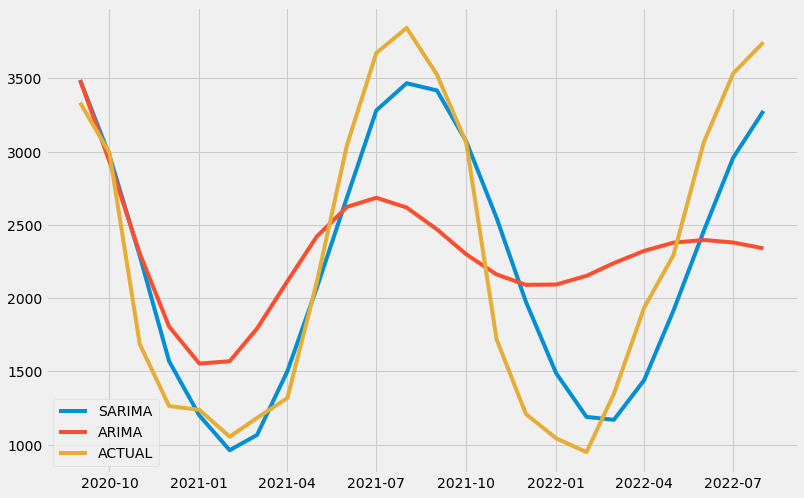

In [ ]:
arima_pred = arima_results.get_forecast(24)
arima_mean = arima_pred.predicted_mean

# Create SARIMA mean forecast
sarima_pred = sarima_results.get_forecast(24)
sarima_mean = sarima_pred.predicted_mean

dates = df.index
# Plot mean ARIMA and SARIMA predictions and observed
plt.plot(dates, sarima_mean, label='SARIMA');
plt.plot(dates, arima_mean, label='ARIMA');
plt.plot(df, label='ACTUAL');
plt.legend();

### Evaluating the models

#### Plot diagnostics

**Test vs Good fit**

Standardized residual: There are no obvious patterns in the residuals

Histogram plus kde estimate:	The KDE curve should be very similar to the normal distribution

Normal Q-Q:	Most of the data points should lie on the straight line

Correlogram:	95% of correlations for lag greater than one should not be significant

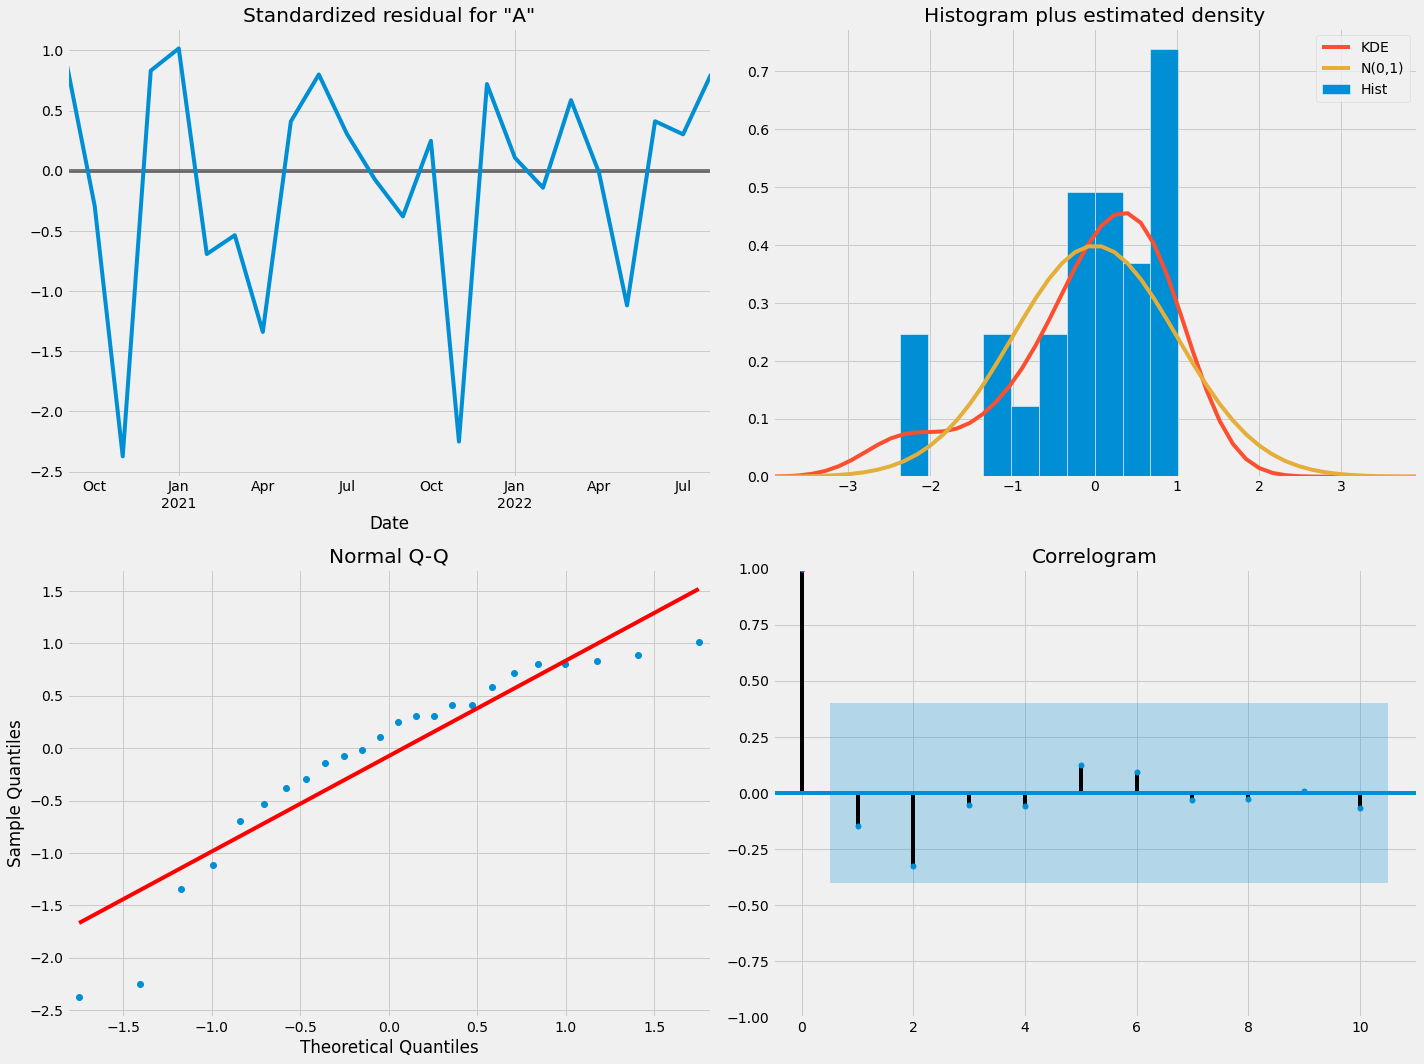

In [ ]:
sarima_results.plot_diagnostics(figsize=(20, 15));
plt.tight_layout();

In [ ]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(sarima_results.resid))

# Print mean absolute error
print(mae)

241.09143093887337


### Future forecast

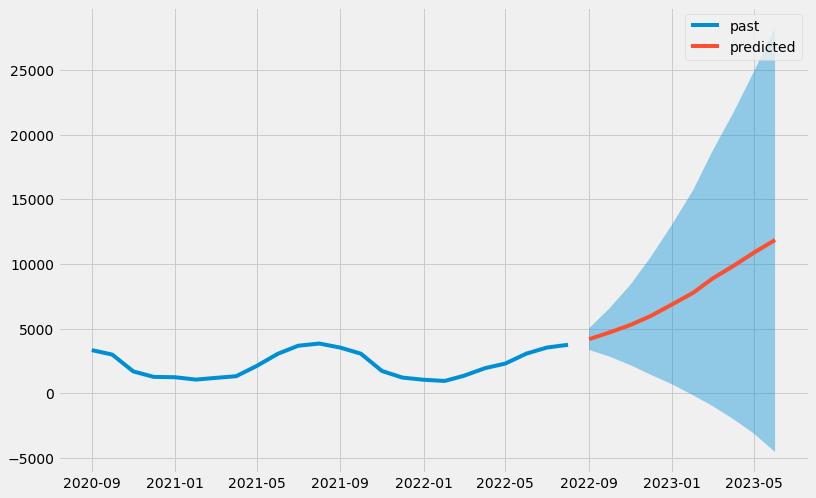

In [ ]:
forecast_object = results.get_forecast(10)

# Extract predicted mean attribute
mean = forecast_object.predicted_mean

# Calculate the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

plt.figure()

# Plot past CO2 levels
plt.plot(df.index, df, label='past');

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted');

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.loc[:, 'lower ACTUAL'],
                 conf_int.loc[:, 'upper ACTUAL'], alpha=0.4);

# Plot legend
plt.legend();

### Printing forecast values for September/2022 to June/2023

In [ ]:
mean

2022-09-01     4182.219304
2022-10-01     4701.635326
2022-11-01     5285.575675
2022-12-01     5992.429604
2023-01-01     6873.416894
2023-02-01     7780.924973
2023-03-01     8868.247596
2023-04-01     9852.537495
2023-05-01    10880.187219
2023-06-01    11852.361317
Freq: MS, Name: predicted_mean, dtype: float64